In [1]:
from pathlib import Path
import os
import shutil
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
from torch import optim
import torch.nn.functional as F
import torch
import torchvision.transforms as T
import torchvision
import glob
import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("runs/MNIST-BRN")

myseed = 4
torch.manual_seed(myseed)
np.random.seed(myseed)

2023-01-27 08:42:25.922642: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [2]:
root_dir = './'
from torchvision import transforms

normalize = T.Normalize(
    mean=[0.1307],
    std=[0.3081]
)

augmentation = T.RandomApply(
    [T.RandomHorizontalFlip(),
     T.RandomCrop(28, padding=4)],
    p=.5
)

# Compose transformations
data_transform = transforms.Compose([
  transforms.Resize(28),
  transforms.ToTensor(),
  augmentation,
  normalize
])

test_transform = transforms.Compose([
  transforms.Resize(28),
  transforms.ToTensor(),
  normalize
])
# Load MNIST dataset with transforms
trainset = torchvision.datasets.MNIST(root=root_dir, train=True, download=True, transform=data_transform)
valset = torchvision.datasets.MNIST(root=root_dir, train=True, download=True, transform=test_transform)
testset = torchvision.datasets.MNIST(root=root_dir, train=False, download=True, transform=test_transform)

In [3]:
num_train = len(trainset)

In [4]:
indices = list(range(num_train))

In [5]:
valid_size = 0.2
split = int(np.floor(valid_size * num_train))

In [6]:
random_seed = 42
shuffle = True
if shuffle:
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [7]:
generator=torch.Generator()
generator.manual_seed(myseed)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, sampler=train_sampler, num_workers=2, drop_last=True, generator=generator)
val_loader = torch.utils.data.DataLoader(valset, batch_size=128, sampler=valid_sampler, num_workers=2, drop_last=False, generator=generator)
test_loader = torch.utils.data.DataLoader(testset, batch_size=128, num_workers=2, drop_last=False, shuffle=False, generator=generator)

In [8]:
# Get number of classes (we'll need it in the model)
num_classes = len(trainset.classes)
# Print dataset statistics
print(f"Num. classes: {num_classes}")
print(f"Classes:\n {trainset.classes}")
print(f"Num. train samples: {len(trainset)}")
print(f"Num. test samples: {len(testset)}")

Num. classes: 10
Classes:
 ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
Num. train samples: 60000
Num. test samples: 10000


Label:  0 - zero (0)


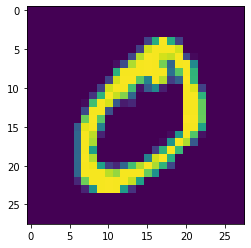

In [9]:
def show_example(img, label):
    print('Label: ', trainset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

show_example(*trainset[1])

In [10]:
def init_params(net):
    '''Init layer parameters.'''
    torch.manual_seed(myseed)
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            init.kaiming_normal(m.weight, mode='fan_out')
            if m.bias:
                init.constant(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            init.constant(m.weight, 1)
            init.constant(m.bias, 0)
        elif isinstance(m, nn.Linear):
            init.kaiming_uniform(m.weight, mode="fan_in")
            #if m.bias:
                #init.kaiming_uniform(m.weight, mode="fan_in")

In [11]:
from torch.nn import Module
class BatchRenormalization2D(Module):

    def __init__(self, num_features,  eps=1e-05, momentum=0.01, r_d_max_inc_step = 0.0001):
        super(BatchRenormalization2D, self).__init__()

        self.eps = eps
        self.momentum = torch.tensor( (momentum), requires_grad = False)

        self.gamma = torch.nn.Parameter(torch.ones((1, num_features, 1, 1)), requires_grad=True)
        self.beta = torch.nn.Parameter(torch.zeros((1, num_features, 1, 1)), requires_grad=True)

        self.running_avg_mean = torch.ones((1, num_features, 1, 1), requires_grad=False)
        self.running_avg_std = torch.zeros((1, num_features, 1, 1), requires_grad=False) 

        self.max_r_max = 3.0
        self.max_d_max = 5.0

        self.r_max_inc_step = r_d_max_inc_step
        self.d_max_inc_step = r_d_max_inc_step

        self.r_max = torch.tensor( (1.0), requires_grad = False)
        self.d_max = torch.tensor( (0.0), requires_grad = False)

    def forward(self, x):

        device = self.gamma.device

        batch_ch_mean = torch.mean(x, dim=(0,2,3), keepdim=True).to(device)
        batch_ch_std = torch.clamp(torch.std(x, dim=(0,2,3), keepdim=True), self.eps, 1e10).to(device)

        self.running_avg_std = self.running_avg_std.to(device)
        self.running_avg_mean = self.running_avg_mean.to(device)
        self.momentum = self.momentum.to(device)

        self.r_max = self.r_max.to(device)
        self.d_max = self.d_max.to(device)


        if self.training:

            r = torch.clamp(batch_ch_std / self.running_avg_std, 1.0 / self.r_max, self.r_max).to(device).data.to(device)
            d = torch.clamp((batch_ch_mean - self.running_avg_mean) / self.running_avg_std, -self.d_max, self.d_max).to(device).data.to(device)

            x = ((x - batch_ch_mean) * r )/ batch_ch_std + d
            x = self.gamma * x + self.beta

            if self.r_max < self.max_r_max:
                self.r_max += self.r_max_inc_step * x.shape[0]

            if self.d_max < self.max_d_max:
                self.d_max += self.d_max_inc_step * x.shape[0]

        else:

            x = (x - self.running_avg_mean) / self.running_avg_std
            x = self.gamma * x + self.beta

        self.running_avg_mean = self.running_avg_mean + self.momentum * (batch_ch_mean.data.to(device) - self.running_avg_mean)
        self.running_avg_std = self.running_avg_std + self.momentum * (batch_ch_std.data.to(device) - self.running_avg_std)

        return x

In [12]:
import torchvision.models as models
import torch.nn.init as init

resnet18 = models.resnet18()
resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)
resnet18.fc = nn.Linear(in_features=512, out_features=10, bias=True)

#MOMENTUM
'''
resnet18.bn1 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)

resnet18.layer1[0].bn1 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
resnet18.layer1[0].bn2 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
resnet18.layer1[1].bn1 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
resnet18.layer1[1].bn2 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)

resnet18.layer2[0].bn1 = nn.BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
resnet18.layer2[0].bn2 = nn.BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
resnet18.layer2[1].bn1 = nn.BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
resnet18.layer2[1].bn2 = nn.BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
resnet18.layer2[0].downsample[1] = nn.GroupNorm(32, 128)

resnet18.layer3[0].bn1 = nn.BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
resnet18.layer3[0].bn2 = nn.BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
resnet18.layer3[1].bn1 = nn.BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
resnet18.layer3[1].bn2 = nn.BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
resnet18.layer3[0].downsample[1] = nn.BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)

resnet18.layer4[0].bn1 = nn.BatchNorm2d(512, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
resnet18.layer4[0].bn2 = nn.BatchNorm2d(512, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
resnet18.layer4[1].bn1 = nn.BatchNorm2d(512, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
resnet18.layer4[1].bn2 = nn.BatchNorm2d(512, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
resnet18.layer4[0].downsample[1] = nn.BatchNorm2d(512, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
'''

#GROUP NORM
'''
resnet18.bn1 = nn.GroupNorm(32, 64)

resnet18.layer1[0].bn1 = nn.GroupNorm(32, 64)
resnet18.layer1[0].bn2 = nn.GroupNorm(32, 64)
resnet18.layer1[1].bn1 = nn.GroupNorm(32, 64)
resnet18.layer1[1].bn2 = nn.GroupNorm(32, 64)

resnet18.layer2[0].bn1 = nn.GroupNorm(32, 128)
resnet18.layer2[0].bn2 = nn.GroupNorm(32, 128)
resnet18.layer2[1].bn1 = nn.GroupNorm(32, 128)
resnet18.layer2[1].bn2 = nn.GroupNorm(32, 128)
resnet18.layer2[0].downsample[1] = nn.GroupNorm(32, 128)

resnet18.layer3[0].bn1 = nn.GroupNorm(32, 256)
resnet18.layer3[0].bn2 = nn.GroupNorm(32, 256)
resnet18.layer3[1].bn1 = nn.GroupNorm(32, 256)
resnet18.layer3[1].bn2 = nn.GroupNorm(32, 256)
resnet18.layer3[0].downsample[1] = nn.GroupNorm(32, 256)

resnet18.layer4[0].bn1 = nn.GroupNorm(32, 512)
resnet18.layer4[0].bn2 = nn.GroupNorm(32, 512)
resnet18.layer4[1].bn1 = nn.GroupNorm(32, 512)
resnet18.layer4[1].bn2 = nn.GroupNorm(32, 512)
resnet18.layer4[0].downsample[1] = nn.GroupNorm(32, 512)
'''

#INSTANCE NORM (E' UNA GROUP NORM CON TANTI GRUPPI TANTI CANALI)
'''
resnet18.bn1 = nn.GroupNorm(64, 64)

resnet18.layer1[0].bn1 = nn.GroupNorm(64, 64)
resnet18.layer1[0].bn2 = nn.GroupNorm(64, 64)
resnet18.layer1[1].bn1 = nn.GroupNorm(64, 64)
resnet18.layer1[1].bn2 = nn.GroupNorm(64, 64)

resnet18.layer2[0].bn1 = nn.GroupNorm(128, 128)
resnet18.layer2[0].bn2 = nn.GroupNorm(128, 128)
resnet18.layer2[1].bn1 = nn.GroupNorm(128, 128)
resnet18.layer2[1].bn2 = nn.GroupNorm(128, 128)
resnet18.layer2[0].downsample[1] = nn.GroupNorm(128, 128)

resnet18.layer3[0].bn1 = nn.GroupNorm(256, 256)
resnet18.layer3[0].bn2 = nn.GroupNorm(256, 256)
resnet18.layer3[1].bn1 = nn.GroupNorm(256, 256)
resnet18.layer3[1].bn2 = nn.GroupNorm(256, 256)
resnet18.layer3[0].downsample[1] = nn.GroupNorm(256, 256)

resnet18.layer4[0].bn1 = nn.GroupNorm(512, 512)
resnet18.layer4[0].bn2 = nn.GroupNorm(512, 512)
resnet18.layer4[1].bn1 = nn.GroupNorm(512, 512)
resnet18.layer4[1].bn2 = nn.GroupNorm(512, 512)
resnet18.layer4[0].downsample[1] = nn.GroupNorm(512, 512)
'''

#LAYER NORM (E' UNA GROUP NORM CON TUTTI I CANALI IN UN SOLO GRUPPO)
'''
resnet18.bn1 = nn.GroupNorm(1, 64)

resnet18.layer1[0].bn1 = nn.GroupNorm(1, 64)
resnet18.layer1[0].bn2 = nn.GroupNorm(1, 64)
resnet18.layer1[1].bn1 = nn.GroupNorm(1, 64)
resnet18.layer1[1].bn2 = nn.GroupNorm(1, 64)

resnet18.layer2[0].bn1 = nn.GroupNorm(1, 128)
resnet18.layer2[0].bn2 = nn.GroupNorm(1, 128)
resnet18.layer2[1].bn1 = nn.GroupNorm(1, 128)
resnet18.layer2[1].bn2 = nn.GroupNorm(1, 128)
resnet18.layer2[0].downsample[1] = nn.GroupNorm(1, 128)

resnet18.layer3[0].bn1 = nn.GroupNorm(1, 256)
resnet18.layer3[0].bn2 = nn.GroupNorm(1, 256)
resnet18.layer3[1].bn1 = nn.GroupNorm(1, 256)
resnet18.layer3[1].bn2 = nn.GroupNorm(1, 256)
resnet18.layer3[0].downsample[1] = nn.GroupNorm(1, 256)

resnet18.layer4[0].bn1 = nn.GroupNorm(1, 512)
resnet18.layer4[0].bn2 = nn.GroupNorm(1, 512)
resnet18.layer4[1].bn1 = nn.GroupNorm(1, 512)
resnet18.layer4[1].bn2 = nn.GroupNorm(1, 512)
resnet18.layer4[0].downsample[1] = nn.GroupNorm(1, 512)
'''

#BATCH RENORMALIZATION

resnet18.bn1 = BatchRenormalization2D(64, eps=1e-05, momentum=0.9)

resnet18.layer1[0].bn1 = BatchRenormalization2D(64, eps=1e-05, momentum=0.9)
resnet18.layer1[0].bn2 = BatchRenormalization2D(64, eps=1e-05, momentum=0.9)
resnet18.layer1[1].bn1 = BatchRenormalization2D(64, eps=1e-05, momentum=0.9)
resnet18.layer1[1].bn2 = BatchRenormalization2D(64, eps=1e-05, momentum=0.9)

resnet18.layer2[0].bn1 = BatchRenormalization2D(128, eps=1e-05, momentum=0.9)
resnet18.layer2[0].bn2 = BatchRenormalization2D(128, eps=1e-05, momentum=0.9)
resnet18.layer2[1].bn1 = BatchRenormalization2D(128, eps=1e-05, momentum=0.9)
resnet18.layer2[1].bn2 = BatchRenormalization2D(128, eps=1e-05, momentum=0.9)
resnet18.layer2[0].downsample[1] = BatchRenormalization2D(128, eps=1e-05, momentum=0.9)

resnet18.layer3[0].bn1 = BatchRenormalization2D(256, eps=1e-05, momentum=0.9)
resnet18.layer3[0].bn2 = BatchRenormalization2D(256, eps=1e-05, momentum=0.9)
resnet18.layer3[1].bn1 = BatchRenormalization2D(256, eps=1e-05, momentum=0.9)
resnet18.layer3[1].bn2 = BatchRenormalization2D(256, eps=1e-05, momentum=0.9)
resnet18.layer3[0].downsample[1] = BatchRenormalization2D(256, eps=1e-05, momentum=0.9)
resnet18.layer4[0].bn1 = BatchRenormalization2D(512, eps=1e-05, momentum=0.9)
resnet18.layer4[0].bn2 = BatchRenormalization2D(512, eps=1e-05, momentum=0.9)
resnet18.layer4[1].bn1 = BatchRenormalization2D(512, eps=1e-05, momentum=0.9)
resnet18.layer4[1].bn2 = BatchRenormalization2D(512, eps=1e-05, momentum=0.9)
resnet18.layer4[0].downsample[1] = BatchRenormalization2D(512, eps=1e-05, momentum=0.9)


# Create the model
model = resnet18
init_params(model)
print(model)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchRenormalization2D()
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchRenormalization2D()
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchRenormalization2D()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchRenormalization2D()
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchRenormalization2D()
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kerne

/tmp/ipykernel_3685117/91120492.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight, mode='fan_out')
/tmp/ipykernel_3685117/91120492.py:13: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(m.weight, mode="fan_in")


In [13]:
list(model.parameters())

[Parameter containing:
 tensor([[[[-2.3774e-02,  3.1902e-02, -4.6409e-03,  ...,  2.7148e-03,
            -7.0214e-03, -6.5714e-02],
           [ 1.5770e-02, -2.1929e-02, -5.1784e-03,  ...,  1.6918e-02,
            -1.3563e-03,  1.1792e-03],
           [-4.4626e-02, -5.3550e-02,  3.8363e-02,  ...,  7.7724e-05,
            -3.8777e-03,  2.8780e-02],
           ...,
           [-1.0645e-02,  2.1436e-02, -1.7111e-02,  ..., -1.2161e-02,
             3.1402e-02,  5.9835e-02],
           [ 7.1454e-03, -5.9230e-03,  4.2660e-02,  ..., -3.4483e-03,
            -1.7546e-02, -3.3299e-02],
           [-2.4481e-02,  1.6169e-02,  2.0711e-02,  ..., -5.4137e-02,
             3.5537e-02, -6.6459e-04]]],
 
 
         [[[ 6.8701e-02, -1.5040e-02,  2.4929e-02,  ...,  1.5400e-03,
             1.0521e-03,  1.7129e-02],
           [-2.2606e-02, -2.5616e-02, -6.1332e-03,  ...,  3.5203e-02,
            -4.9007e-03,  1.2168e-04],
           [-3.3246e-02,  5.1521e-04, -4.1717e-03,  ...,  1.3049e-02,
             

In [14]:
torch.cuda.is_available()

dev = torch.device('cuda')
print(dev)

cuda


In [15]:
num_epochs=200

In [16]:
# Define an optimizier
import torch.optim as optim
#optimizer = optim.SGD([x for x in model.parameters() if x.requires_grad], lr = 0.1, momentum=0.9, weight_decay=0.0005)
optimizer = optim.Adam([x for x in model.parameters() if x.requires_grad], lr=0.0001)
#optimizer = optim.AdamW([x for x in model.parameters() if x.requires_grad], lr=0.001, weight_decay=0.02)
# Define a loss 
criterion = nn.CrossEntropyLoss()
#scheduler
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = 0.01, epochs=2, steps_per_epoch=312)


In [17]:
def train(net, loaders, optimizer, criterion, epochs=100, dev=torch.device('cuda')):
    torch.manual_seed(myseed)
    try:
        net = net.to(dev)
        print(net)
        # Initialize history
        history_loss = {"train": [], "val": [], "test": []}
        history_accuracy = {"train": [], "val": [], "test": []}
        # Process each epoch
        for epoch in range(epochs):
            # Initialize epoch variables
            sum_loss = {"train": 0, "val": 0, "test": 0}
            sum_accuracy = {"train": 0, "val": 0, "test": 0}
            # Process each split
            for split in ["train", "val", "test"]:
                # Process each batch
                for (input, labels) in loaders[split]:
                    # Move to CUDA
                    input = input.to(dev)
                    labels = labels.to(dev)
                    # Reset gradients
                    optimizer.zero_grad()
                    # Compute output
                    pred = net(input)
                    loss = criterion(pred, labels)
                    # Update loss
                    sum_loss[split] += loss.item()
                    # Check parameter update
                    if split == "train":
                        # Compute gradients
                        loss.backward()
                        # Optimize
                        optimizer.step()
                    # Compute accuracy
                    _,pred_labels = pred.max(1)
                    batch_accuracy = (pred_labels == labels).sum().item()/input.size(0)
                    # Update accuracy
                    sum_accuracy[split] += batch_accuracy
                scheduler.step()
            # Compute epoch loss/accuracy
            epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            # Update history
            for split in ["train", "val", "test"]:
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])
                
            writer.add_scalar("Train Loss", epoch_loss['train'], epoch)
            writer.add_scalar("Valid Loss", epoch_loss['val'], epoch)
            writer.add_scalar("Test Loss", epoch_loss['test'], epoch)
            writer.add_scalar("Train Accuracy", epoch_accuracy['train'], epoch)
            writer.add_scalar("Valid Accuracy", epoch_accuracy['val'], epoch)
            writer.add_scalar("Test Accuracy", epoch_accuracy['test'], epoch)                
                
            # Print info
            print(f"Epoch {epoch+1}:",
                  f"TrL={epoch_loss['train']:.4f},",
                  f"TrA={epoch_accuracy['train']:.4f},",
                  f"VL={epoch_loss['val']:.4f},",
                  f"VA={epoch_accuracy['val']:.4f},",
                  f"TeL={epoch_loss['test']:.4f},",
                  f"TeA={epoch_accuracy['test']:.4f},",
                  f"LR={optimizer.param_groups[0]['lr']:.5f},")
    except KeyboardInterrupt:
        print("Interrupted")
    finally:
        # Plot loss
        plt.title("Loss")
        for split in ["train", "val", "test"]:
            plt.plot(history_loss[split], label=split)
        plt.legend()
        plt.show()
        # Plot accuracy
        plt.title("Accuracy")
        for split in ["train", "val", "test"]:
            plt.plot(history_accuracy[split], label=split)
        plt.legend()
        plt.show()

# Define dictionary of loaders
loaders = {"train": train_loader,
           "val": val_loader,
           "test": test_loader}

/home/lmancuso/anaconda3/envs/openfl/lib/python3.8/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchRenormalization2D()
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchRenormalization2D()
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchRenormalization2D()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchRenormalization2D()
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchRenormalization2D()
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kerne

Epoch 52: TrL=0.0471, TrA=0.9878, VL=0.0646, VA=0.9843, TeL=0.0750, TeA=0.9804, LR=0.00939,
Epoch 53: TrL=0.0521, TrA=0.9862, VL=0.0562, VA=0.9857, TeL=0.0642, TeA=0.9838, LR=0.00950,
Epoch 54: TrL=0.0491, TrA=0.9867, VL=0.0359, VA=0.9914, TeL=0.0445, TeA=0.9888, LR=0.00961,
Epoch 55: TrL=0.0461, TrA=0.9876, VL=0.0387, VA=0.9897, TeL=0.0509, TeA=0.9882, LR=0.00970,
Epoch 56: TrL=0.0523, TrA=0.9867, VL=0.0590, VA=0.9855, TeL=0.0829, TeA=0.9798, LR=0.00978,
Epoch 57: TrL=0.1625, TrA=0.9745, VL=0.5623, VA=0.8940, TeL=0.9634, TeA=0.8413, LR=0.00984,
Epoch 58: TrL=0.1673, TrA=0.9635, VL=0.0497, VA=0.9892, TeL=0.0634, TeA=0.9840, LR=0.00990,
Epoch 59: TrL=0.0512, TrA=0.9861, VL=0.0487, VA=0.9887, TeL=0.0594, TeA=0.9863, LR=0.00994,
Epoch 60: TrL=0.0395, TrA=0.9896, VL=0.0416, VA=0.9905, TeL=0.0497, TeA=0.9870, LR=0.00997,
Epoch 61: TrL=0.0422, TrA=0.9883, VL=0.0445, VA=0.9890, TeL=0.0594, TeA=0.9831, LR=0.00999,
Epoch 62: TrL=0.0450, TrA=0.9881, VL=0.0359, VA=0.9903, TeL=0.0388, TeA=0.9894, 

Epoch 141: TrL=0.0154, TrA=0.9958, VL=0.0394, VA=0.9924, TeL=0.0504, TeA=0.9908, LR=0.00434,
Epoch 142: TrL=0.0143, TrA=0.9961, VL=0.0421, VA=0.9927, TeL=0.0515, TeA=0.9916, LR=0.00423,
Epoch 143: TrL=0.0126, TrA=0.9969, VL=0.0509, VA=0.9923, TeL=0.0684, TeA=0.9884, LR=0.00413,
Epoch 144: TrL=0.0112, TrA=0.9970, VL=0.0530, VA=0.9911, TeL=0.0794, TeA=0.9831, LR=0.00402,
Epoch 145: TrL=0.0145, TrA=0.9960, VL=0.0455, VA=0.9914, TeL=0.0788, TeA=0.9866, LR=0.00392,
Epoch 146: TrL=0.0114, TrA=0.9972, VL=0.0468, VA=0.9911, TeL=0.0576, TeA=0.9897, LR=0.00381,
Epoch 147: TrL=0.0128, TrA=0.9964, VL=0.0479, VA=0.9902, TeL=0.0598, TeA=0.9894, LR=0.00371,
Epoch 148: TrL=0.0105, TrA=0.9970, VL=0.0365, VA=0.9922, TeL=0.0579, TeA=0.9906, LR=0.00360,
Epoch 149: TrL=0.0098, TrA=0.9973, VL=0.0471, VA=0.9920, TeL=0.0647, TeA=0.9889, LR=0.00350,
Epoch 150: TrL=0.0108, TrA=0.9968, VL=0.0483, VA=0.9915, TeL=0.0621, TeA=0.9892, LR=0.00340,
Epoch 151: TrL=0.0112, TrA=0.9969, VL=0.0370, VA=0.9926, TeL=0.0698, T

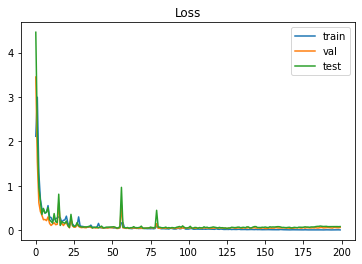

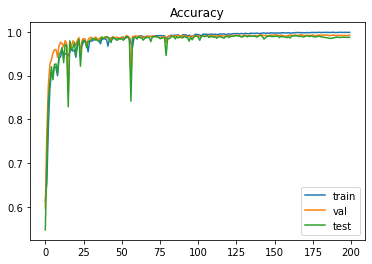

In [18]:
# Train model
train(model, loaders, optimizer, criterion, epochs=num_epochs, dev=dev)
writer.flush()

In [19]:
writer.close()